# Analizing Football  Database
#### Data Science Fundamentals - Talento Digital | Udacity

I'll be working with the european football (2008-2016) database provided from Udacity. You can find the original database <a href="https://www.kaggle.com/hugomathien/soccer">here</a> thanks to Kaggle user <a href="https://www.kaggle.com/hugomathien/soccer">Hugo Mathien</a>.<br><br>

In this analisys I'll have as objective awnser questions related to goalkeepers:<br>
    -Which is the most effective goalkeeper in the last session?<br>
    -Which is the most constant goalkeeper through his active years?<br>
    -Top 10 goalkeepers of lalst season.<br>
    -How does the height and weight affect performance?
<br>
<br>
As this database extrac the information from the game Fifa, all the analysis could be bias.

<a id="index"></a>
# Content Table:

   - [Dictionary](#dict)
   - [Install Libraries](#install)
   - [Importing](#import)
   - [Data Wrangling](#wrangling)<br>
       -[Working with "rare" columns](#rare)
   - [Exploratory Data Analysis](#analysis)

<a id="Dict"></a>
## Dictionary
The columns id for teams and players are related to a "api_id" and in its specific table are related to fifa_api_id

<a id="install"></a>
## Install libraries
First I need to install all de libraries, as I'm working in Jupyter Lab I will install through here.<br>
If you all ready have installed this libraries in your computer is not necessary to run this.<br><br>
As explain in this [page] is better installing packages with the command below to aboid problems with the pip version and current python kernel.
<br>
<br>
[Back to content table](#index)

[page]:https://jakevdp.github.io/blog/2017/12/05/installing-python-packages-from-jupyter/

In [1]:
import sys
#!{sys.executable} -m pip install pandas
#!{sys.executable} -m pip install plotly
#!{sys.executable} -m pip install pysqlite3
#!{sys.executable} -m pip install xmltodict

### For Plotly Express to work in Jupyter Lab I need to install Node.js
#!{sys.executable} -m curl -sL https://deb.nodesource.com/setup_15.x | sudo -E bash -
#!{sys.executable} -m sudo apt-get install -y nodejs

#### And then run this command
#!{sys.executable} -m jupyter labextension install jupyterlab-plotly@4.14.3


<a id="import"></a>
## Importing
First thin will be import the libraries that I'll use. As the data is in a SQLite we need the library to extract and work with data.
<br>
<br>
[Back to content table](#index)

In [2]:
import pandas as pd
import numpy as np
import plotly.express as px
import sqlite3 as sql
import xmltodict
import re

### Setting Options
pd.set_option('display.max_columns', None)

<a id="wrangling"><a/>
## Data Wrangling and Cleaning

First I will load all tables from the .sqlite database, only for if I need something from another table. This will be loaded through Pandas.<br>
From the match columns I will not load the "betting odds" columns.
<br>
<br>
[Back to content table](#index)

In [3]:
database = "/home/anonimo/Documentos/Talento Digital/Analizing Football Database/football_database.sqlite"
connection = sql.connect(database)
q_country = '''SELECT * FROM Country'''
q_league = '''SELECT * FROM League'''
q_match = '''SELECT `id`, `country_id`, `league_id`, `season`, `stage`, `date`, `match_api_id`, `home_team_api_id`,
`away_team_api_id`, `home_team_goal`, `away_team_goal`, `home_player_1`, `home_player_2`, `home_player_3`, `home_player_4`,
`home_player_5`, `home_player_6`, `home_player_7`, `home_player_8`, `home_player_9`, `home_player_10`, `home_player_11`,
`away_player_1`, `away_player_2`, `away_player_3`, `away_player_4`, `away_player_5`, `away_player_6`, `away_player_7`,
`away_player_8`, `away_player_9`, `away_player_10`, `away_player_11`, `goal`, `shoton`, `shotoff`, `foulcommit`, `card`,
`cross`, `corner`, `possession` FROM Match'''
q_player = '''SELECT * FROM Player'''
q_player_attributes = '''SELECT * FROM Player_Attributes'''
q_team = '''SELECT * FROM Team'''
q_team_attributes = '''SELECT * FROM Team_Attributes'''

In [4]:
df_country = pd.read_sql_query(q_country, connection)
df_league = pd.read_sql_query(q_league, connection)
df_match= pd.read_sql_query(q_match, connection)
df_player = pd.read_sql_query(q_player, connection)
df_player_attributes = pd.read_sql_query(q_player_attributes, connection)
df_team = pd.read_sql_query(q_team, connection)
df_team_attributes = pd.read_sql_query(q_team_attributes, connection)

<br>I willl search for the Goalkeepers (GK). As I played Fifa I know that the meaning of GK attributes will need to be around 50 or 60 points to be a GK, so for the rest of players that doesn't match with at least 60 points in each GK attribute will be droped<br>
<br>
Working with the data I see a lot of missing values so I will procced only to take in analysis the England Premier League (EPL), since its has more data.

In [5]:
df_player_attributes.columns

Index(['id', 'player_fifa_api_id', 'player_api_id', 'date', 'overall_rating',
       'potential', 'preferred_foot', 'attacking_work_rate',
       'defensive_work_rate', 'crossing', 'finishing', 'heading_accuracy',
       'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy',
       'long_passing', 'ball_control', 'acceleration', 'sprint_speed',
       'agility', 'reactions', 'balance', 'shot_power', 'jumping', 'stamina',
       'strength', 'long_shots', 'aggression', 'interceptions', 'positioning',
       'vision', 'penalties', 'marking', 'standing_tackle', 'sliding_tackle',
       'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning',
       'gk_reflexes'],
      dtype='object')

In [6]:
df_player_attributes = df_player_attributes[(df_player_attributes['gk_diving'] > 60) \
                                            & (df_player_attributes['gk_handling'] > 60) \
                                            & (df_player_attributes['gk_kicking'] > 60) \
                                            & (df_player_attributes['gk_positioning'] > 60) \
                                            & (df_player_attributes['gk_reflexes'] > 60)]

df_player_attributes['date'] = pd.to_datetime(df_player_attributes['date'], format='%Y-%m-%d')

In [7]:
gk_players = df_player_attributes['player_api_id'].unique().tolist()

Here I need to only select GK from players table. For this I use the `gk_players` list create adobe.

In [8]:
df_player = df_player[df_player['player_api_id'].isin(gk_players)]
df_player.drop(columns=['player_fifa_api_id'], inplace=True)

Here I need to:
1. Only filter by EPL.
2. If is home_player_X reffers always to a GK.
3. Drop the rest of the home_player_X that aren't GKs.
4. Drop country, league and match_api_id columns.

With the help of DB Browser I see that `home_player_1` and `away_player_1` reffers always to a GK.

In [9]:
df_match.columns

Index(['id', 'country_id', 'league_id', 'season', 'stage', 'date',
       'match_api_id', 'home_team_api_id', 'away_team_api_id',
       'home_team_goal', 'away_team_goal', 'home_player_1', 'home_player_2',
       'home_player_3', 'home_player_4', 'home_player_5', 'home_player_6',
       'home_player_7', 'home_player_8', 'home_player_9', 'home_player_10',
       'home_player_11', 'away_player_1', 'away_player_2', 'away_player_3',
       'away_player_4', 'away_player_5', 'away_player_6', 'away_player_7',
       'away_player_8', 'away_player_9', 'away_player_10', 'away_player_11',
       'goal', 'shoton', 'shotoff', 'foulcommit', 'card', 'cross', 'corner',
       'possession'],
      dtype='object')

In [10]:
id_premier = df_league[df_league['name'].isin(['England Premier League'])].id
df_match = df_match[df_match['league_id'] == int(id_premier)]

In [11]:
df_match.drop(columns=['country_id',
                       'league_id',
                       'match_api_id',
                       'goal',
                       'foulcommit',
                       'card',
                       'cross',
                       'corner',
                       'possession',
                       'home_player_2',
                       'home_player_3',
                       'home_player_4',
                       'home_player_5',
                       'home_player_6',
                       'home_player_7',
                       'home_player_8',
                       'home_player_9',
                       'home_player_10',
                       'home_player_11',
                       'away_player_2',
                       'away_player_3',
                       'away_player_4',
                       'away_player_5',
                       'away_player_6',
                       'away_player_7',
                       'away_player_8',
                       'away_player_9',
                       'away_player_10',
                       'away_player_11'],
             inplace=True)

In [12]:
df_match.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3040 entries, 1728 to 4767
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                3040 non-null   int64  
 1   season            3040 non-null   object 
 2   stage             3040 non-null   int64  
 3   date              3040 non-null   object 
 4   home_team_api_id  3040 non-null   int64  
 5   away_team_api_id  3040 non-null   int64  
 6   home_team_goal    3040 non-null   int64  
 7   away_team_goal    3040 non-null   int64  
 8   home_player_1     3040 non-null   float64
 9   away_player_1     3040 non-null   float64
 10  shoton            3040 non-null   object 
 11  shotoff           3040 non-null   object 
dtypes: float64(2), int64(6), object(4)
memory usage: 308.8+ KB


#### Merge tables
1. As to merge I need columns match between tables I need to separate in 2 DataFrames home and away match.
2. Now as I don't have any missing values I will procced to merge the tables in `df_match`:<br>
    a. `df_player`<br>
    b. `df_team`
<br>

In [13]:
df_home = df_match.copy()
df_away = df_match.copy()

#df_home.drop(columns=['away_team_api_id', 'away_player_1'], inplace=True)
#df_away.drop(columns=['home_team_api_id', 'home_player_1'], inplace=True)

df_home.rename(columns={'home_player_1':'player_api_id'}, inplace=True)
df_away.rename(columns={'away_player_1':'player_api_id'}, inplace=True)

df_home['player_api_id'] = df_home['player_api_id'].astype(int)
df_away['player_api_id'] = df_away['player_api_id'].astype(int)

df_home['date'] = pd.to_datetime(df_home['date'], format='%Y-%m-%d')
df_away['date'] = pd.to_datetime(df_away['date'], format='%Y-%m-%d')

In [14]:
df_home = pd.merge(df_home, df_player, how='left', on='player_api_id')
df_away = pd.merge(df_away, df_player, how='left', on='player_api_id')

df_home.rename(columns={'id_x':'id'}, inplace=True)
df_away.rename(columns={'id_x':'id'}, inplace=True)

df_home.drop(columns='id_y', inplace=True)
df_away.drop(columns='id_y', inplace=True)

In [15]:
df_home.rename(columns={'home_team_api_id':'team_api_id'}, inplace=True)
df_away.rename(columns={'away_team_api_id':'team_api_id'}, inplace=True)

df_home = pd.merge(df_home, df_team, how='left', on='team_api_id')
df_away = pd.merge(df_away, df_team, how='left', on='team_api_id')

df_home.rename(columns={'id_x':'id'}, inplace=True)
df_away.rename(columns={'id_x':'id'}, inplace=True)

df_home.drop(columns=['id_y', 'team_fifa_api_id'], inplace=True)
df_away.drop(columns=['id_y', 'team_fifa_api_id'], inplace=True)

<a id="rare"></a>
### Working with "rare" columns
As for the analysing that I want to do the infomation in columns `shoton` and `shotoff` it's crucial, so I need to extract the data and bring the information that I want to the `df_home`/`df_away` table.<br><br>
As soon I start to working find problems:<br><br>
    1) Data inside these columns are "write in an personal HTML type" so I need to transform into DataFrame. After a lot of searching and break my head I find that the lenguage it was XML and find a library that can parse.<br>
    2) Inside these new tables ara "nan" values so I need to replace these values.<br>
    3) I need to extract the count of "shooton" and "shootoff" for the correct team in evaluation and "paste" in the `df_home`/`df_away` table
<br>
<br>
[Back to content table](#index)

#### Shot on

for the analysis I search one of the match in internet and found that the shot on target in this data base not count the goal of the team.<br><br>

For example for the match `1729` (Manchester United vs Newcastle United, 17/08/2008) the team `10260` (Manchester United) has 6 shot on target and 1 goal in this database. In the oficial web from the <a href="https://www.premierleague.com/match/6336">Premier League</a> have 7 shot on target and 1 goal.

In [16]:
df_home['shoton'] = df_home['shoton'].apply(lambda x: xmltodict.parse(str(x)))
df_home['shoton'] = df_home['shoton'].apply(pd.Series)
df_home['shoton'] = df_home['shoton'].apply(lambda x: pd.DataFrame(x['value']))

In [17]:
for i in range(len(list(df_home['shoton']))):
    df_home['shoton'][i]['stats'].fillna(df_home['shoton'][i]['subtype'], inplace=True)

In [18]:
for i in range(len(list(df_home['shoton']))):
        for j in range(len(list(df_home['shoton'][i]['stats']))):
            try:
                df_home['shoton'][i]['stats'][j] = list(df_home['shoton'][i]['stats'][j].items())[0][0]
            except:
                continue

In [19]:
df_away['shoton'] = df_away['shoton'].apply(lambda x: xmltodict.parse(str(x)))
df_away['shoton'] = df_away['shoton'].apply(pd.Series)
df_away['shoton'] = df_away['shoton'].apply(lambda x: pd.DataFrame(x['value']))

In [20]:
for i in range(len(list(df_away['shoton']))):
    df_away['shoton'][i]['stats'].fillna(df_away['shoton'][i]['subtype'], inplace=True)

In [21]:
for i in range(len(list(df_away['shoton']))):
        for j in range(len(list(df_away['shoton'][i]['stats']))):
            try:
                df_away['shoton'][i]['stats'][j] = list(df_away['shoton'][i]['stats'][j].items())[0][0]
            except:
                continue

#### Shot Off

In [22]:
df_home['shotoff'] = df_home['shotoff'].apply(lambda x: xmltodict.parse(str(x)))
df_home['shotoff'] = df_home['shotoff'].apply(pd.Series)
df_home['shotoff'] = df_home['shotoff'].apply(lambda x: pd.DataFrame(x['value']))

In [23]:
for i in range(len(list(df_home['shotoff']))):
    df_home['shotoff'][i]['stats'].fillna(df_home['shotoff'][i]['subtype'], inplace=True)

In [24]:
for i in range(len(list(df_home['shotoff']))):
        for j in range(len(list(df_home['shotoff'][i]['stats']))):
            try:
                df_home['shotoff'][i]['stats'][j] = list(df_home['shotoff'][i]['stats'][j].items())[0][0]
            except:
                continue

In [25]:
df_away['shotoff'] = df_away['shotoff'].apply(lambda x: xmltodict.parse(str(x)))
df_away['shotoff'] = df_away['shotoff'].apply(pd.Series)
df_away['shotoff'] = df_away['shotoff'].apply(lambda x: pd.DataFrame(x['value']))

In [26]:
for i in range(len(list(df_away['shotoff']))):
    df_away['shotoff'][i]['stats'].fillna(df_away['shotoff'][i]['subtype'], inplace=True)

In [27]:
for i in range(len(list(df_away['shotoff']))):
        for j in range(len(list(df_away['shotoff'][i]['stats']))):
            try:
                df_away['shotoff'][i]['stats'][j] = list(df_away['shotoff'][i]['stats'][j].items())[0][0]
            except:
                continue

#### Transfer

In [28]:
list_home_shoton = []
for i in range(len(df_home['shoton'])):
    team = df_home['away_team_api_id'][i]
    list_home_shoton.append(dict(df_home['shoton'][i][df_home['shoton'][i]['team'] == str(team)]['stats'].value_counts()).get('shoton'))
    
df_home['shot_on'] = list_home_shoton
df_home['shot_on'].fillna(0, inplace=True)

In [29]:
list_home_shotoff = []
for i in range(len(df_home['shotoff'])):
    team = df_home['away_team_api_id'][i]
    list_home_shotoff.append(dict(df_home['shotoff'][i][df_home['shotoff'][i]['team'] == str(team)]['stats'].value_counts()).get('shotoff'))
    
df_home['shot_off'] = list_home_shotoff
df_home['shot_off'].fillna(0, inplace=True)

In [30]:
list_away_shoton = []
for i in range(len(df_away['shoton'])):
    team = df_away['home_team_api_id'][i]
    list_away_shoton.append(dict(df_away['shoton'][i][df_away['shoton'][i]['team'] == str(team)]['stats'].value_counts()).get('shoton'))
    
df_away['shot_on'] = list_away_shoton
df_away['shot_on'].fillna(0, inplace=True)

In [31]:
list_away_shotoff = []
for i in range(len(df_away['shotoff'])):
    team = df_away['home_team_api_id'][i]
    list_away_shotoff.append(dict(df_away['shotoff'][i][df_away['shotoff'][i]['team'] == str(team)]['stats'].value_counts()).get('shotoff'))
    
df_away['shot_off'] = list_away_shotoff
df_away['shot_off'].fillna(0, inplace=True)

#### Adding ratios

In [32]:
df_home['ratio_save'] = (df_home['home_team_goal'] / (df_home['shot_on'] + df_home['home_team_goal']))

<a id="analysis"></a>
## Exploratory Data Analysis
For now as sanity reason I will only analise the last season 2015/2016.
<br>
<br>
[Back to content table](#index)

Select columns to see how 

In [33]:
df_home.columns

Index(['id', 'season', 'stage', 'date', 'team_api_id', 'away_team_api_id',
       'home_team_goal', 'away_team_goal', 'player_api_id', 'away_player_1',
       'shoton', 'shotoff', 'player_name', 'birthday', 'height', 'weight',
       'team_long_name', 'team_short_name', 'shot_on', 'shot_off',
       'ratio_save'],
      dtype='object')

In [49]:
season_2015_2016 = df_home[df_home['season'] == '2015/2016'].groupby('player_name')[['height', 'weight', 'shot_on', 'home_team_goal', 'ratio_save']].mean().reset_index()
match_played_2015_2016 = (pd.DataFrame(df_home[df_home['season'] == '2015/2016']['player_name'].value_counts())/19).round(4).reset_index()
match_played_2015_2016.columns = ['player_name', 'ratio_match_played']
season_2015_2016 = season_2015_2016.merge(match_played_2015_2016, left_on='player_name', right_on='player_name', how='left')
#season_2015_2016 = season_2015_2016[season_2015_2016['ratio_match_played'] >= 0.6]
season_2015_2016 = season_2015_2016.sort_values(by='ratio_match_played', ascending=False)
season_2015_2016['weight'] = (season_2015_2016['weight'] * 0.453592).round(2)
season_2015_2016

,player_name,height,weight,shot_on,home_team_goal,ratio_save,ratio_match_played
15,Hugo Lloris,187.96,78.02,2.421053,1.842105,0.451003,1.0000
14,Heurelho Gomes,190.50,82.10,3.263158,1.052632,0.276587,1.0000
21,Kasper Schmeichel,185.42,76.20,2.789474,1.842105,0.437037,1.0000
31,Simon Mignolet,193.04,87.09,2.000000,1.736842,0.502381,1.0000
27,Petr Cech,195.58,89.81,3.666667,1.500000,0.317989,0.9474
24,Lukasz Fabianski,190.50,83.01,2.833333,1.055556,0.261953,0.9474
17,Joe Hart,195.58,91.17,2.166667,2.444444,0.553439,0.9474
3,Artur Boruc,193.04,87.09,2.352941,1.176471,0.341176,0.8947
10,David De Gea,193.04,82.10,1.764706,1.529412,0.452661,0.8947
1,Adrian,187.96,77.11,2.866667,1.666667,0.355556,0.7895


There are correlations between `height`, `weight`, `ratio_save` and `ratio_match_played`?

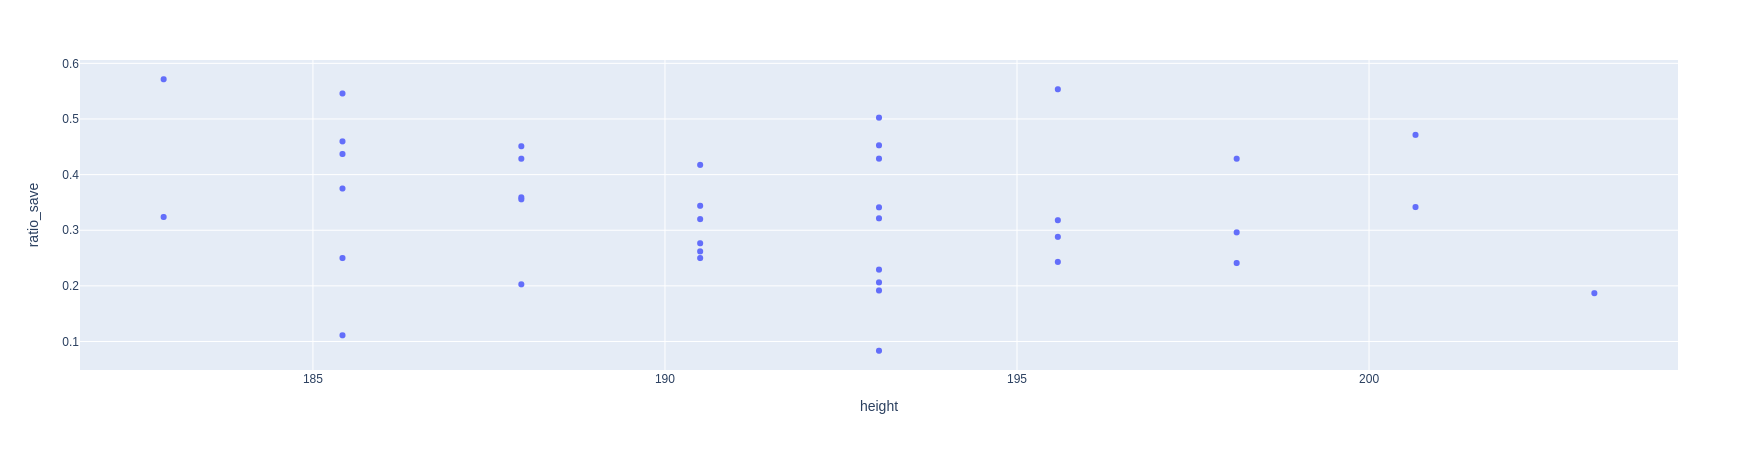

In [50]:
px.scatter(season_2015_2016, x='height', y='ratio_save', hover_name='player_name')

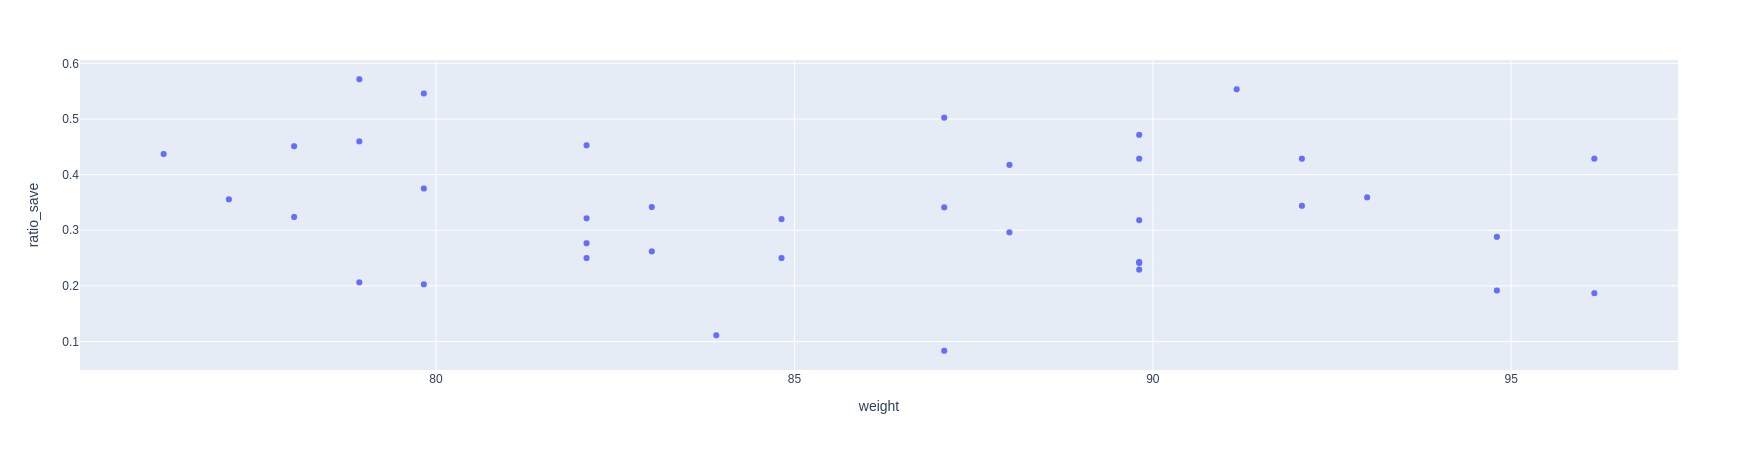

In [51]:
px.scatter(season_2015_2016, x='weight', y='ratio_save', hover_name='player_name')

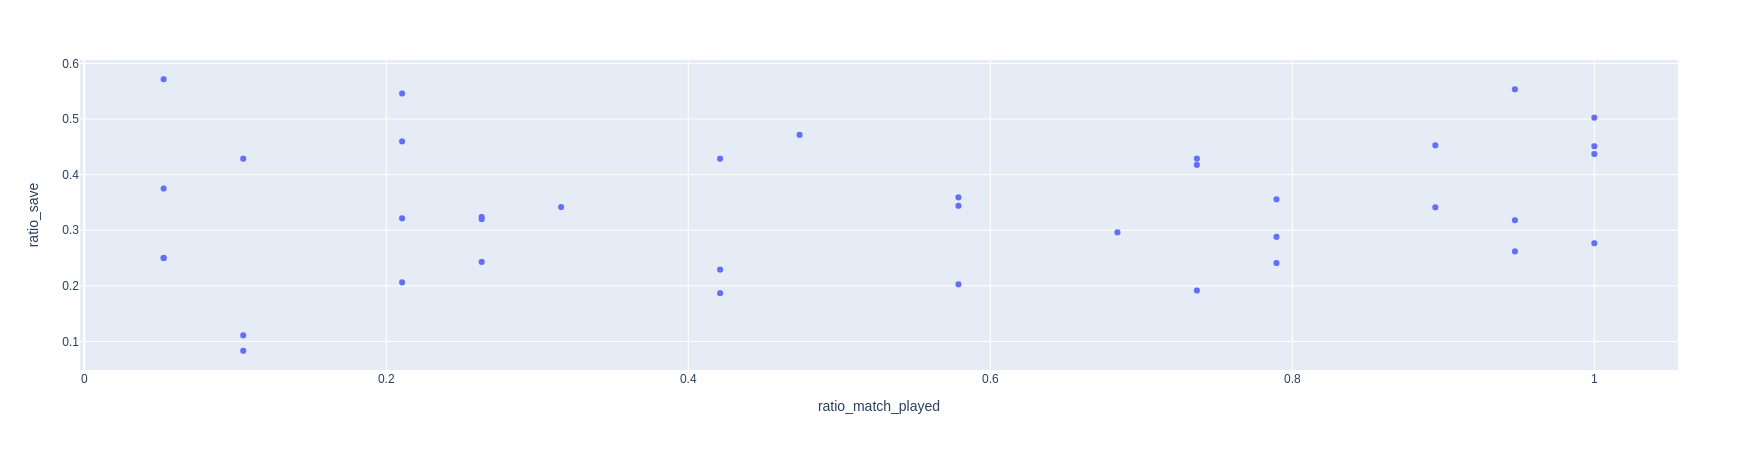

In [52]:
px.scatter(season_2015_2016, x='ratio_match_played', y='ratio_save', hover_name='player_name')

Looking the plotters I can see any evidence, at least with the season of 2015/2016, that exist correlation, negative or positive, between `weigth`, `height` and `ratio_saved`

In [36]:
match_played = pd.DataFrame(df_home.groupby('season')['player_name'].value_counts())
match_played = match_played.unstack(0)
match_played['total'] = match_played.mean(axis=1).round(1)
match_played.sort_values('total', ascending=False)
match_played = match_played.div(19).round(2)
#match_played[match_played.index.isin(['Adam Bogdan'], level=0)]

In [37]:
most_played = match_played.copy()
most_played.dropna(thresh=5, inplace=True)
most_played = most_played[most_played['total'] >= 0.6]
gk_analysis = list(most_played.index)
most_played.columns = list(df_home['season'].unique())+['total']
most_played

,2008/2009,2009/2010,2010/2011,2011/2012,2012/2013,2013/2014,2014/2015,2015/2016,total
player_name,,,,,,,,,
Asmir Begovic,0.05,0.37,0.74,0.58,1.00,0.89,0.95,0.32,0.61
Ben Foster,NaN,0.26,1.00,0.95,0.84,0.63,0.74,0.42,0.69
Brad Friedel,1.00,1.00,1.00,1.00,0.26,0.05,NaN,NaN,0.72
Brad Guzan,NaN,NaN,NaN,0.16,0.95,1.00,0.84,0.74,0.74
David De Gea,NaN,NaN,NaN,0.74,0.74,1.00,1.00,0.89,0.87
Heurelho Gomes,0.89,0.84,0.84,NaN,NaN,NaN,NaN,1.00,0.89
Hugo Lloris,NaN,NaN,NaN,NaN,0.74,0.95,0.95,1.00,0.91
Joe Hart,0.63,0.95,1.00,1.00,1.00,0.79,0.95,0.95,0.91
John Ruddy,NaN,NaN,NaN,0.95,0.37,1.00,NaN,0.74,0.76


Which is the mean ratio save for every GK in each season?

In [38]:
mean_season.columns
list(df_home['season'].unique())

NameError: name 'mean_season' is not defined

In [ ]:
pd.set_option('display.max_rows', None) # 60 originaly
mean_season = pd.DataFrame((df_home.groupby(['season', 'player_name'])['ratio_save', 'height', 'weight'].mean()).round(4))
mean_season = mean_season.unstack(0)
mean_season['total'] = mean_season.mean(axis=1).round(1)
#mean_season.columns = list(df_home['season'].unique())+['total']
mean_season = mean_season[mean_season.index.isin(gk_analysis, level=0)].swaplevel(0, axis=1)
mean_season.columns = [list(mean_season.columns)[x][0]+'_'+list(mean_season.columns)[x][1] for x in range(len(list(mean_season.columns)))]
mean_season.drop('_total', axis=1)

Multiply the `ratio_saved` with `match_played`, this will output a value weighted by how many match the GK played.

In [ ]:
new_df = mean_season * top_23_played
new_df.dropna(how='all')

#### Creating a new DataFrame

In [ ]:
df = mean_season['ratio_save'].merge(match_played['player_name'], on='player_name', how='left')
df = pd.DataFrame(df_home['player_name'].unique(), columns=['player_name'])

In [ ]:
df = df.merge(df_home[df_home['season'] == '2008/2009'].groupby(['player_name']).ratio_save.mean(), on='player_name', how='left')
df = df.merge(df_home[df_home['season'] == '2009/2010'].groupby(['player_name']).ratio_save.mean(), on='player_name', how='left')
df = df.merge(df_home[df_home['season'] == '2010/2011'].groupby(['player_name']).ratio_save.mean(), on='player_name', how='left')
df = df.merge(df_home[df_home['season'] == '2011/2012'].groupby(['player_name']).ratio_save.mean(), on='player_name', how='left')
df = df.merge(df_home[df_home['season'] == '2012/2013'].groupby(['player_name']).ratio_save.mean(), on='player_name', how='left')
df = df.merge(df_home[df_home['season'] == '2013/2014'].groupby(['player_name']).ratio_save.mean(), on='player_name', how='left')
df = df.merge(df_home[df_home['season'] == '2014/2015'].groupby(['player_name']).ratio_save.mean(), on='player_name', how='left')
df = df.merge(df_home[df_home['season'] == '2015/2016'].groupby(['player_name']).ratio_save.mean(), on='player_name', how='left')

In [ ]:
names_columns = ['player_names'] + list(df_home['season'].unique())
df.columns = names_columns

In [ ]:
df_home.columns

In [ ]:
pd.DataFrame((df_home.groupby(['season', 'player_name'])['ratio_save', 'height', 'weight'].mean()*100).round(1))

In [ ]:
try_ = pd.DataFrame(df_home.groupby(['season', 'player_name'])['shot_on'].value_counts())

In [ ]:
try_

<a id="last"></a>
_________________________________________